In [1]:
import sys
sys.path.append('..')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
import taiko as tk
from taiko.tools.config import *
from taiko.play import get_play, get_similarity
from taiko.performance import get_performance
from taiko.database import load_record_df

import lightgbm as lgb
from itertools import product
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import posixpath
import multiprocessing
from sklearn.preprocessing import StandardScaler

sns.set(font_scale=1.5)

Using TensorFlow backend.


In [3]:
SONG_ID = 1

In [4]:
record_df = load_record_df(song_id=SONG_ID)
record_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime
1,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05
5,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13
9,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41
13,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23
25,carolyn,1,L_2018-09-27_154913.csv,R_2018-09-27_154916.csv,capture_2018_09_27_15_49_16
29,carolyn,1,L_2018-09-27_160509.csv,R_2018-09-27_160510.csv,capture_2018_09_27_16_05_10
33,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26
37,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11
42,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21
46,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57


In [5]:
play_result_df = pd.read_csv(PLAY_RESULT_TABLE_PATH)
play_result_df.drop(['drummer_name', 'song_id', 'capture_datetime'], axis=1, inplace=True)
play_record_df = record_df.merge(play_result_df, left_index=True, right_on='id', how='inner')
play_record_df['note'] = play_record_df['good'] + play_record_df['ok'] + play_record_df['bad']
play_record_df = play_record_df[play_record_df['note'] == ALL_NOTE_COUNT_DICT[SONG_ID]]
play_record_df.drop('note', axis=1, inplace=True)
play_record_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
4,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13,5,2,989360,84,2,0,86,63
8,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41,9,3,979660,84,2,0,86,68
12,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23,13,4,991060,84,2,0,86,74
16,carolyn,1,L_2018-09-27_154913.csv,R_2018-09-27_154916.csv,capture_2018_09_27_15_49_16,25,1,792630,54,30,2,84,42
20,carolyn,1,L_2018-09-27_160509.csv,R_2018-09-27_160510.csv,capture_2018_09_27_16_05_10,29,2,803450,57,25,4,61,48
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
28,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11,37,4,913960,71,15,0,86,47
32,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21,42,1,978860,82,4,0,86,94
35,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57,46,2,994710,85,1,0,86,95


In [6]:
full_combo_df = play_record_df[play_record_df['bad'] == 0]
full_combo_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
4,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13,5,2,989360,84,2,0,86,63
8,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41,9,3,979660,84,2,0,86,68
12,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23,13,4,991060,84,2,0,86,74
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
28,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11,37,4,913960,71,15,0,86,47
32,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21,42,1,978860,82,4,0,86,94
35,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57,46,2,994710,85,1,0,86,95
38,celiven,1,L_2018-09-22_144040.csv,R_2018-09-22_144039.csv,capture_2018_09_22_14_40_39,50,3,989460,84,2,0,86,94
40,celiven,1,L_2018-09-22_145139.csv,R_2018-09-22_145139.csv,capture_2018_09_22_14_51_38,54,4,999560,86,0,0,86,50


In [7]:
# test
# CONSIDERED_IDS = [61, 150]

# doraemon individual
# CONSIDERED_IDS = [1, 33, 61, 99, 150, 180, 241, 254, 288, 323]

# doraemon individual for two occurance
# CONSIDERED_IDS = [1, 5, 33, 37, 61, 65, 99, 107, 141, 150, 180, 181, 241, 249, 254, 258, 288, 310, 323, 327]

# RPG individual for two occurance
# CONSIDERED_IDS = [10, 14, 52, 56, 79, 83, 121, 125, 155, 159, 208, 216, 280, 284, 311, 315, 350, 354]

# all
CONSIDERED_IDS = play_record_df['id'].values

# full combo
# CONSIDERED_IDS = full_combo_df['id'].values

CONSIDERED_IDS

array([  1,   5,   9,  13,  25,  29,  33,  37,  42,  46,  50,  54,  61,
        65,  69,  76,  78,  82,  86,  90,  95,  99, 103, 107, 112, 116,
       120, 124, 129, 133, 137, 141, 146, 150, 154, 158, 163, 167, 171,
       175, 179, 180, 181, 182, 203, 207, 211, 215, 224, 228, 232, 237,
       241, 245, 249, 254, 258, 262, 266, 271, 275, 279, 283, 288, 292,
       296, 300, 306, 310, 314, 318, 323, 327, 331, 335, 341, 345, 349,
       353])

In [8]:
pfs = []
for id_ in tqdm(CONSIDERED_IDS, total=len(CONSIDERED_IDS)):
    pf = get_performance(id_)
    pfs.append(pf)
        
play_record_df[play_record_df['id'].isin(CONSIDERED_IDS)]

100%|██████████| 79/79 [00:00<00:00, 86.05it/s]


,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
4,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13,5,2,989360,84,2,0,86,63
8,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41,9,3,979660,84,2,0,86,68
12,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23,13,4,991060,84,2,0,86,74
16,carolyn,1,L_2018-09-27_154913.csv,R_2018-09-27_154916.csv,capture_2018_09_27_15_49_16,25,1,792630,54,30,2,84,42
20,carolyn,1,L_2018-09-27_160509.csv,R_2018-09-27_160510.csv,capture_2018_09_27_16_05_10,29,2,803450,57,25,4,61,48
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
28,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11,37,4,913960,71,15,0,86,47
32,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21,42,1,978860,82,4,0,86,94
35,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57,46,2,994710,85,1,0,86,95


In [9]:
model_name = 'lgbm_model.h5'
model = lgb.Booster(model_file=model_name)
plot_df = pd.DataFrame({'features': model.feature_name(),
                        'importances': model.feature_importance()})
plot_df = plot_df.sort_values('importances', ascending=False)
plot_df = plot_df.head(5)
feature_columns = list(plot_df['features'])
feature_columns

['R_AY_AI', 'R_AZ_AI', 'L_AY_AI', 'R_AY_MMI', 'L_AY_MMI']

In [10]:
pf_row_count = len(pfs[0])
for i_, _ in enumerate(pfs):
    pfs[i_] = pfs[i_][feature_columns]

In [11]:
# HANDS = ['L', 'R']
SIMILARITY_COLUMNS = [str(a) + '_' + b for a, b in product(range(pf_row_count), feature_columns)]
SIMILARITY_COLUMNS
len(SIMILARITY_COLUMNS)

9210

In [12]:
similarity_mat = []
with multiprocessing.Pool() as p:
    result = p.starmap(get_similarity, product(pfs, repeat=2))
    ids = list(product(CONSIDERED_IDS, repeat=2))
    for ids_, sim in zip(ids, result):
        similarity_mat.append(list(ids_) + list(sim))
#         sim = get_similarity(row1[1], row2[1])
#         similarity_mat.append([row1[0], row2[0], sim[0], sim[1]])
#         print(sim)

similarity_df = pd.DataFrame(data=similarity_mat)
similarity_df.columns = ['a_id', 'b_id'] + SIMILARITY_COLUMNS
similarity_df

,a_id,b_id,0_R_AY_AI,0_R_AZ_AI,0_L_AY_AI,0_R_AY_MMI,0_L_AY_MMI,1_R_AY_AI,1_R_AZ_AI,1_L_AY_AI,...,1840_R_AY_AI,1840_R_AZ_AI,1840_L_AY_AI,1840_R_AY_MMI,1840_L_AY_MMI,1841_R_AY_AI,1841_R_AZ_AI,1841_L_AY_AI,1841_R_AY_MMI,1841_L_AY_MMI
0,1,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,1,5,5.9106,15.5426,13.7744,11.7188,1.1302,4.7400,12.7502,2.8000,...,7.5910,6.2085,-3.9357,0.2136,0.4118,7.1173,6.1323,-3.6267,1.3671,0.3702
2,1,9,-20.1242,-11.3948,16.8083,0.4273,0.6149,-19.9491,-14.2026,3.5323,...,32.0915,-25.4104,-4.3273,-31.2622,-0.2830,17.1227,-19.3881,-5.9768,-39.0747,-0.4036
3,1,13,4.5059,15.6479,13.0395,13.4644,1.0928,2.7715,12.5777,2.1544,...,8.2583,7.5593,-4.2927,2.5085,0.2844,7.5466,7.3774,-4.4605,1.8493,0.2476
4,1,25,-1.1623,-3.0839,13.7679,5.9205,1.1470,-1.9576,-7.1836,3.8686,...,9.9840,9.0895,-2.1338,2.8015,0.4083,9.6600,9.0224,-1.7306,2.9968,0.3667
5,1,29,1.6242,13.2636,10.4931,10.4065,1.1681,1.4980,10.2075,0.1643,...,10.9303,-3.5686,-5.6654,-47.5891,-1.5572,9.7228,-3.8142,-10.9204,-59.0271,-2.0414
6,1,33,-7.9146,-3.2798,19.2663,-14.4561,-2.5268,-7.1754,-4.5072,3.3150,...,11.0007,7.5777,-1.5470,-2.0844,0.4173,11.9766,6.4069,0.4141,-2.0936,0.2632
7,1,37,6.4804,15.3235,13.9745,12.7869,1.2043,5.0697,12.5740,3.5583,...,10.0345,4.5015,-3.7621,2.5512,0.4147,11.5727,4.6091,-1.3526,2.7161,0.3120
8,1,42,6.8834,14.4255,14.3905,10.1288,1.0878,5.3288,11.2691,3.3149,...,4.7902,-16.5936,-28.0431,-5.9449,-0.0378,-0.1746,-12.9289,-22.0110,-5.9449,0.0206
9,1,46,27.9322,-96.8368,-69.1772,-138.1592,-2.4094,41.8004,-100.5953,-85.9118,...,-18.4266,-29.3422,-8.9052,-40.7654,-4.6295,1.9845,-29.7938,0.0984,-51.4099,-4.6323


In [13]:
dtw_df = similarity_df.copy()
dtw_df['same'] = (dtw_df['a_id'] == dtw_df['b_id'])
dtw_df = dtw_df[~dtw_df['same']].drop('same', axis=1)
# for col in SIMILARITY_COLUMNS:
#     sns.distplot(dtw_df[col])
#     plt.show()

In [14]:
scaler = StandardScaler()
dtw_df[SIMILARITY_COLUMNS] = scaler.fit_transform(dtw_df[SIMILARITY_COLUMNS])
# dtw_df['acc_dtw'] -= dtw_df.min(axis=0)['acc_dtw']
# dtw_df['gyr_dtw'] -= dtw_df.min(axis=0)['gyr_dtw']
dtw_df['norm_sim'] = dtw_df[SIMILARITY_COLUMNS].mean(axis=1)
dtw_df

,a_id,b_id,0_R_AY_AI,0_R_AZ_AI,0_L_AY_AI,0_R_AY_MMI,0_L_AY_MMI,1_R_AY_AI,1_R_AZ_AI,1_L_AY_AI,...,1840_R_AZ_AI,1840_L_AY_AI,1840_R_AY_MMI,1840_L_AY_MMI,1841_R_AY_AI,1841_R_AZ_AI,1841_L_AY_AI,1841_R_AY_MMI,1841_L_AY_MMI,norm_sim
1,1,5,0.232168,0.385390,0.648783,0.326022,0.836669,0.158909,0.309798,0.134106,...,0.176402,-0.153455,0.007529,0.261709,0.384826,0.180709,-0.162772,0.047944,0.235517,0.178977
2,1,9,-0.790476,-0.282542,0.791682,0.011888,0.455201,-0.668797,-0.345088,0.169180,...,-0.721985,-0.168724,-1.101904,-0.179854,0.925810,-0.571335,-0.268249,-1.370334,-0.256766,0.173989
3,1,13,0.176991,0.388001,0.614169,0.374585,0.808983,0.092915,0.305607,0.103185,...,0.214782,-0.167375,0.088417,0.180743,0.408038,0.217400,-0.200195,0.064854,0.157520,0.209449
4,1,25,-0.045655,-0.076468,0.648477,0.164711,0.849106,-0.065629,-0.174543,0.185287,...,0.258260,-0.083198,0.098745,0.259485,0.522308,0.265875,-0.077672,0.105097,0.233290,0.240080
5,1,29,0.063798,0.328880,0.494232,0.289513,0.864726,0.050221,0.248017,0.007869,...,-0.101395,-0.220897,-1.677381,-0.989640,0.525704,-0.112398,-0.490126,-2.070057,-1.298714,0.150743
6,1,33,-0.310885,-0.081325,0.907455,-0.402175,-1.870551,-0.240557,-0.109514,0.158772,...,0.215305,-0.060318,-0.073469,0.265205,0.647565,0.188801,0.018586,-0.073422,0.167445,0.213895
7,1,37,0.254549,0.379957,0.658208,0.355737,0.891525,0.169963,0.305517,0.170425,...,0.127901,-0.146686,0.089923,0.263552,0.625726,0.135823,-0.060707,0.095253,0.198491,0.230306
8,1,42,0.270379,0.357691,0.677802,0.281788,0.805281,0.178649,0.273811,0.158768,...,-0.471474,-1.093415,-0.209541,-0.024023,-0.009440,-0.380993,-0.987891,-0.208485,0.013105,0.119418
9,1,46,1.097173,-2.401138,-3.258291,-3.843648,-1.783641,1.401366,-2.444214,-4.114759,...,-0.833700,-0.347218,-1.436865,-2.942163,0.107300,-0.877974,0.004416,-1.802925,-2.947014,0.018691
10,1,50,0.055173,-0.655351,2.583353,-0.348601,0.361851,0.139210,-0.581847,2.039290,...,-2.553146,-3.345196,-2.058166,-2.501109,1.284467,-2.479485,-2.936851,-1.729078,-2.530184,0.083159


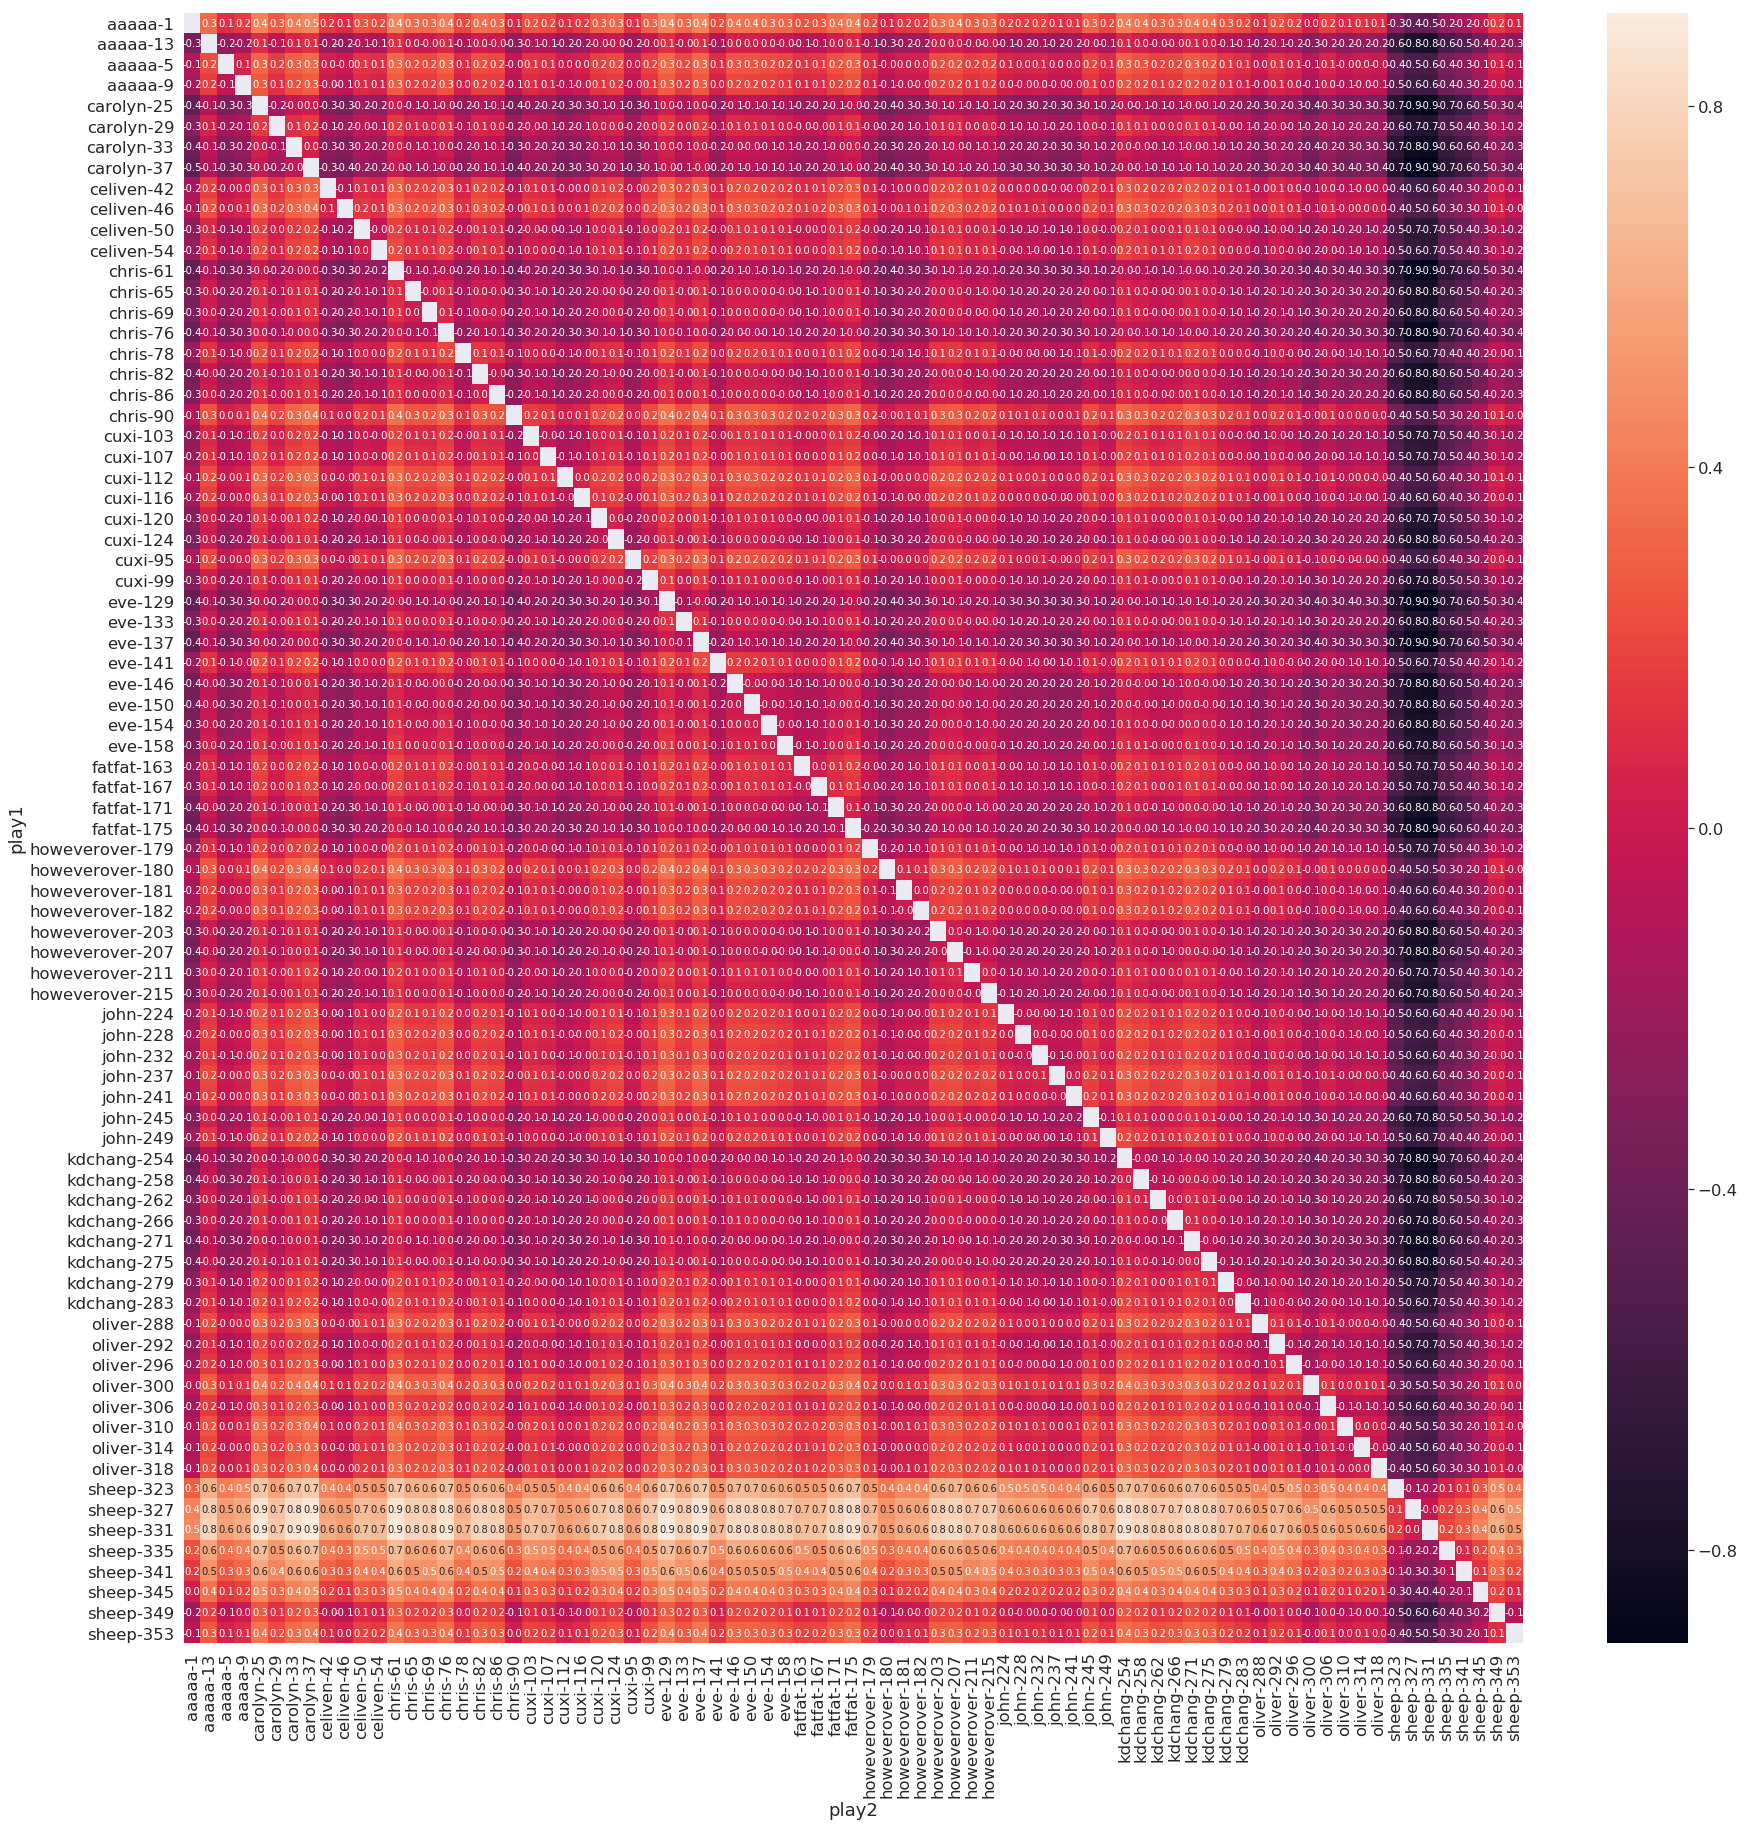

In [15]:
vis_right_df = play_record_df.copy()
vis_right_df = vis_right_df[['drummer_name', 'id']]

vis_df = dtw_df.merge(vis_right_df, left_on='a_id', right_on='id', how='inner')
vis_df = vis_df.merge(vis_right_df, left_on='b_id', right_on='id', how='inner')
vis_df.drop(['id_x', 'id_y'], axis=1, inplace=True)
vis_df = vis_df.rename(index=str, columns={'drummer_name_x': 'a_drummer_name',
                                  'drummer_name_y': 'b_drummer_name'})
vis_df['a_id'] = vis_df['a_id'].apply(str)
vis_df['b_id'] = vis_df['b_id'].apply(str)
vis_df['play1'] = vis_df[['a_drummer_name', 'a_id']].apply(lambda x: '-'.join(x), axis=1)
vis_df['play2'] = vis_df[['b_drummer_name', 'b_id']].apply(lambda x: '-'.join(x), axis=1)
vis_df = vis_df.pivot('play1', 'play2', 'norm_sim')
plt.figure(figsize=(30, 30))
ax = sns.heatmap(vis_df, annot=True, fmt='.1f')

# LGBM

In [15]:
import lightgbm as lgb
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [16]:
score_right_df = play_record_df.copy()
score_right_df = score_right_df[['score', 'id']]

score_df = dtw_df.copy()
score_df = score_df.merge(score_right_df, left_on='a_id', right_on='id', how='inner')
score_df = score_df.merge(score_right_df, left_on='b_id', right_on='id', how='inner')
score_df = score_df[score_df['a_id'] < score_df['b_id']]
score_df.drop(['id_x', 'id_y'], axis=1, inplace=True)
score_df['score_dif'] = np.abs(score_df['score_x'] - score_df['score_y'])
score_df.drop(['score_x', 'score_y'], axis=1, inplace=True)
score_df

,a_id,b_id,0_R_AY_AI,0_R_AZ_AI,0_L_AY_AI,0_R_AY_MMI,0_L_AY_MMI,1_R_AY_AI,1_R_AZ_AI,1_L_AY_AI,...,1840_L_AY_AI,1840_R_AY_MMI,1840_L_AY_MMI,1841_R_AY_AI,1841_R_AZ_AI,1841_L_AY_AI,1841_R_AY_MMI,1841_L_AY_MMI,norm_sim,score_dif
0,1,5,0.232168,0.385390,0.648783,0.326022,0.836669,0.158909,0.309798,0.134106,...,-0.153455,0.007529,0.261709,0.384826,0.180709,-0.162772,0.047944,0.235517,0.178977,14250
78,1,9,-0.790476,-0.282542,0.791682,0.011888,0.455201,-0.668797,-0.345088,0.169180,...,-0.168724,-1.101904,-0.179854,0.925810,-0.571335,-0.268249,-1.370334,-0.256766,0.173989,4550
79,5,9,-1.022644,-0.667932,0.142899,-0.314134,-0.381469,-0.827707,-0.654886,0.035074,...,-0.015269,-1.109433,-0.441563,0.540984,-0.752044,-0.105476,-1.418278,-0.492282,-0.004988,9700
156,1,13,0.176991,0.388001,0.614169,0.374585,0.808983,0.092915,0.305607,0.103185,...,-0.167375,0.088417,0.180743,0.408038,0.217400,-0.200195,0.064854,0.157520,0.209449,15950
157,5,13,-0.055176,0.002611,-0.034614,0.048563,-0.027687,-0.065994,-0.004191,-0.030921,...,-0.013920,0.080889,-0.080966,0.023212,0.036691,-0.037422,0.016911,-0.077997,0.030471,1700
158,9,13,0.967467,0.670543,-0.177513,0.362698,0.353782,0.761712,0.650694,-0.065995,...,0.001349,1.190321,0.360597,-0.517772,0.788735,0.068054,1.435188,0.414286,0.035460,11400
234,1,25,-0.045655,-0.076468,0.648477,0.164711,0.849106,-0.065629,-0.174543,0.185287,...,-0.083198,0.098745,0.259485,0.522308,0.265875,-0.077672,0.105097,0.233290,0.240080,182480
235,5,25,-0.277823,-0.461857,-0.000306,-0.161311,0.012437,-0.224538,-0.484341,0.051181,...,0.070257,0.091216,-0.002224,0.137482,0.085167,0.085100,0.057153,-0.002227,0.061103,196730
236,9,25,0.744821,0.206075,-0.143205,0.152823,0.393905,0.603168,0.170544,0.016107,...,0.085526,1.200649,0.439338,-0.403502,0.837211,0.190577,1.475431,0.490056,0.066091,187030
237,13,25,-0.222646,-0.464468,0.034308,-0.209875,0.040123,-0.158544,-0.480150,0.082102,...,0.084177,0.010327,0.078742,0.114270,0.048475,0.122523,0.040242,0.075770,0.030632,198430


In [17]:
train_df = score_df.drop(['a_id', 'b_id', 'norm_sim'], axis=1).copy()
x = train_df.drop('score_dif', axis=1)
y = train_df['score_dif']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, random_state=0, test_size=0.5)

train_df

,0_R_AY_AI,0_R_AZ_AI,0_L_AY_AI,0_R_AY_MMI,0_L_AY_MMI,1_R_AY_AI,1_R_AZ_AI,1_L_AY_AI,1_R_AY_MMI,1_L_AY_MMI,...,1840_R_AZ_AI,1840_L_AY_AI,1840_R_AY_MMI,1840_L_AY_MMI,1841_R_AY_AI,1841_R_AZ_AI,1841_L_AY_AI,1841_R_AY_MMI,1841_L_AY_MMI,score_dif
0,0.232168,0.385390,0.648783,0.326022,0.836669,0.158909,0.309798,0.134106,0.309732,1.252370,...,0.176402,-0.153455,0.007529,0.261709,0.384826,0.180709,-0.162772,0.047944,0.235517,14250
78,-0.790476,-0.282542,0.791682,0.011888,0.455201,-0.668797,-0.345088,0.169180,0.008728,0.849959,...,-0.721985,-0.168724,-1.101904,-0.179854,0.925810,-0.571335,-0.268249,-1.370334,-0.256766,4550
79,-1.022644,-0.667932,0.142899,-0.314134,-0.381469,-0.827707,-0.654886,0.035074,-0.301005,-0.402411,...,-0.898388,-0.015269,-1.109433,-0.441563,0.540984,-0.752044,-0.105476,-1.418278,-0.492282,9700
156,0.176991,0.388001,0.614169,0.374585,0.808983,0.092915,0.305607,0.103185,0.342333,1.290401,...,0.214782,-0.167375,0.088417,0.180743,0.408038,0.217400,-0.200195,0.064854,0.157520,15950
157,-0.055176,0.002611,-0.034614,0.048563,-0.027687,-0.065994,-0.004191,-0.030921,0.032601,0.038031,...,0.038380,-0.013920,0.080889,-0.080966,0.023212,0.036691,-0.037422,0.016911,-0.077997,1700
158,0.967467,0.670543,-0.177513,0.362698,0.353782,0.761712,0.650694,-0.065995,0.333606,0.440442,...,0.936768,0.001349,1.190321,0.360597,-0.517772,0.788735,0.068054,1.435188,0.414286,11400
234,-0.045655,-0.076468,0.648477,0.164711,0.849106,-0.065629,-0.174543,0.185287,0.233494,1.014578,...,0.258260,-0.083198,0.098745,0.259485,0.522308,0.265875,-0.077672,0.105097,0.233290,182480
235,-0.277823,-0.461857,-0.000306,-0.161311,0.012437,-0.224538,-0.484341,0.051181,-0.076239,-0.237792,...,0.081858,0.070257,0.091216,-0.002224,0.137482,0.085167,0.085100,0.057153,-0.002227,196730
236,0.744821,0.206075,-0.143205,0.152823,0.393905,0.603168,0.170544,0.016107,0.224766,0.164619,...,0.980245,0.085526,1.200649,0.439338,-0.403502,0.837211,0.190577,1.475431,0.490056,187030
237,-0.222646,-0.464468,0.034308,-0.209875,0.040123,-0.158544,-0.480150,0.082102,-0.108839,-0.275823,...,0.043478,0.084177,0.010327,0.078742,0.114270,0.048475,0.122523,0.040242,0.075770,198430


In [30]:
train_set = lgb.Dataset(x_train, y_train)
valid_set = lgb.Dataset(x_valid, y_valid, free_raw_data=False)
watchlist = [valid_set]

params = dict({
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'application': 'rmse',
#     'min_data_in_leaf': 3,
    'max_depth': 1000,
#     'num_leaves': 2 ** 6,
    'verbosity': 0,
#     'metric': 'rmse'
})

grid_params = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [8, 10],
}

model = lgb.train(params, train_set=train_set, valid_sets=watchlist,
                  num_boost_round=500, verbose_eval=10, early_stopping_rounds=20)
y_pred = model.predict(x_test, num_iteration=model.best_iteration)

Training until validation scores don't improve for 20 rounds.
[10]	valid_0's rmse: 77461.8
[20]	valid_0's rmse: 70576.8
[30]	valid_0's rmse: 66784.3
[40]	valid_0's rmse: 64769.3
[50]	valid_0's rmse: 63740.6
[60]	valid_0's rmse: 63114.8
[70]	valid_0's rmse: 62697.9
[80]	valid_0's rmse: 62527.8
[90]	valid_0's rmse: 62273.6
[100]	valid_0's rmse: 62126.7
[110]	valid_0's rmse: 62015.6
[120]	valid_0's rmse: 61917.5
[130]	valid_0's rmse: 61889.3
[140]	valid_0's rmse: 61844.1
[150]	valid_0's rmse: 61823.4
[160]	valid_0's rmse: 61805.1
[170]	valid_0's rmse: 61797.3
[180]	valid_0's rmse: 61773
[190]	valid_0's rmse: 61773.5
[200]	valid_0's rmse: 61760.6
[210]	valid_0's rmse: 61763.9
[220]	valid_0's rmse: 61757.8
[230]	valid_0's rmse: 61748.2
[240]	valid_0's rmse: 61752.1
[250]	valid_0's rmse: 61751.5
Early stopping, best iteration is:
[232]	valid_0's rmse: 61746.6


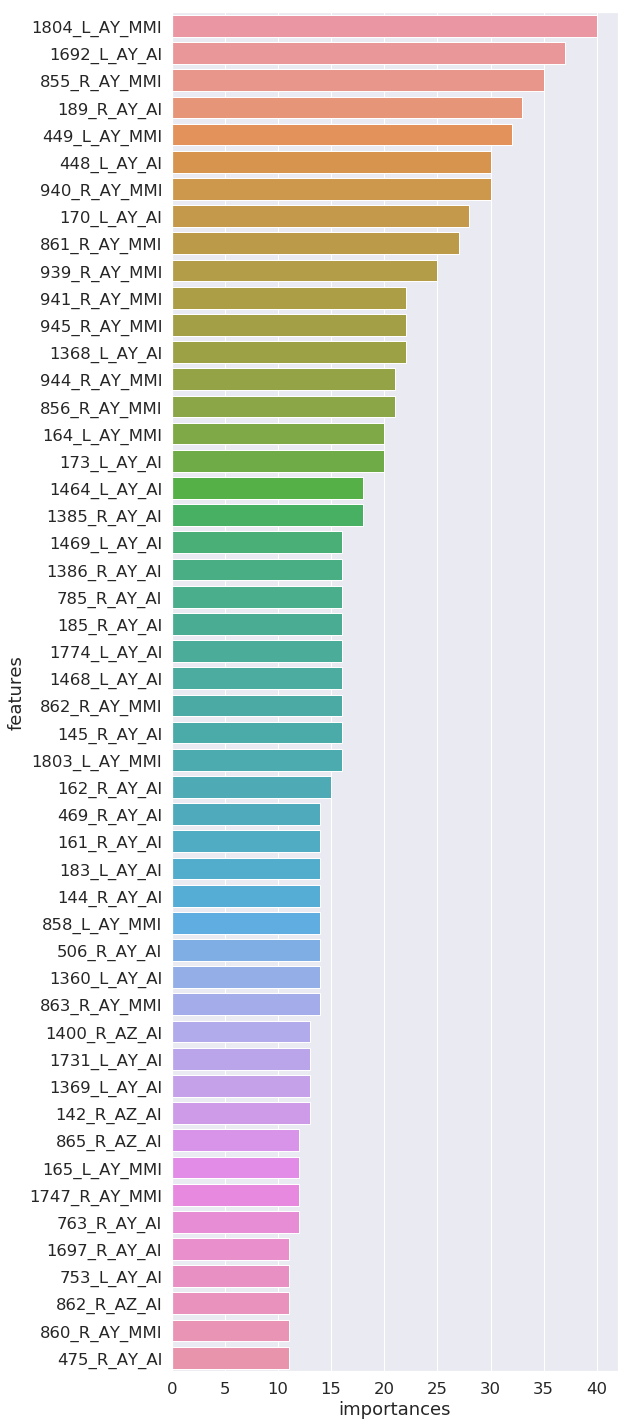

In [31]:
plot_df = pd.DataFrame({'features': train_df.columns[train_df.columns != 'score_dif'],
                        'importances': model.feature_importance()})
plot_df = plot_df.sort_values('importances', ascending=False)

plot_df = plot_df.head(50)
plt.figure(figsize=(8, 25))
sns.barplot(x = plot_df.importances, y = plot_df.features)
plt.show()

In [32]:
y_pred

array([191034.94570801,  96690.47388016,  91561.65377459, 141185.38653804,
        35128.62174701, 124682.81512312, 377152.37054797, 178435.34024877,
       129360.36397741,  54924.78732688, 376249.65935245,  98726.99510293,
       116715.60670847,  27578.15048272,  68573.1722306 ,  74261.84614938,
       117947.075714  ,  94837.55361976,  58885.14433924,  63285.06628226,
        59544.31247917,  34374.51725417,  86153.18852143,  56377.80306352,
       128390.86059473,  59226.70678339, 139524.78728333, 123805.85439015,
       113462.36000346,  61617.17766282, 103274.68509597, 102427.02193987,
        42367.57610512,  36862.23944536,  66036.19386466, 116075.28051114,
        45629.93367746,  80037.50633714,  89875.18749092,  76252.88783395,
        71300.13522383, 255857.5377951 , 109713.97326979, 141977.96565242,
       212062.83539419, 100174.83815748, 100123.04268207,  78506.09435461,
        71054.58823976,  78342.19812699, 120390.00241667,  16702.17230401,
       351849.37880793,  

In [28]:
y_test

4884    211760
5657     15950
4882     43700
5433     27380
3526     12700
4959    147950
5499    423400
4232    177880
5319    125840
312     171660
6045    454500
4318    137660
2263    186570
1105     10790
5562     47150
4158     68150
5393    174970
6066     36250
3433     10200
4841    143010
5232     62460
3361     69450
5814     25450
5896     12200
3695     15520
4682     37650
6074    110510
3765    144600
3827     10790
4408     89160
         ...  
2363     82050
5528     79410
5086    173590
2968    253520
2424     95290
2126     75170
5862     69730
3385     91350
5262    217100
316      10820
4071    104100
5800    210960
4529    159260
2754    270060
2734    126630
1951     42400
3980    127700
5273    101510
4300     75100
2189     53230
3138    452780
3435      8500
3215     36250
4459     94100
4817      5650
3834     93990
2284    145380
4680     33100
2205    192190
5281    209110
Name: score_dif, Length: 617, dtype: int64

In [33]:
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

The rmse of prediction is: 59135.09318478393
